In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [28]:
dataset = load_dataset("pawlo2013/augmented_chest_xray", split="train")
dataset = dataset.shuffle(seed=42)
labels_list = dataset['label'] 
le = LabelEncoder()
le.fit(labels_list)
def encode_label(example):
    example['label'] = le.transform([example['label']])[0]
    return example

dataset = dataset.map(encode_label)
train_test = dataset.train_test_split(test_size=0.25)
train_ds = train_test["train"]
test_ds = train_test["test"]
print(train_test)
print(train_ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 17311
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5771
    })
})
Dataset({
    features: ['image', 'label'],
    num_rows: 17311
})


In [29]:
def transform(example):
    try:
        img = np.array(example["image"], dtype=np.float32)

        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)

        img = tf.convert_to_tensor(img)

        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        img = tf.image.resize(img, [256, 256])
        img = preprocess_input(img)

        label = example["label"]
        return img, label

    except Exception as e:
        print(f"Skipped corrupted or bad image: {e}")
        return tf.zeros((256, 256, 3), dtype=tf.float32), 0

def gen(dataset):
    for ex in dataset:
        yield transform(ex)

output_signature = (
    tf.TensorSpec(shape=(256,256,3), dtype=tf.float32),   # adjust as needed
    tf.TensorSpec(shape=(), dtype=tf.int64),
)
ds_train = tf.data.Dataset.from_generator(lambda: gen(train_ds), output_signature=output_signature)
ds_train = ds_train.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)  # batching keeps RAM low!
ds_test = tf.data.Dataset.from_generator(lambda: gen(test_ds), output_signature=output_signature)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)  # batching keeps RAM low!

In [30]:
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
convolutional_base.trainable = False
convolutional_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
num_of_classes = len(le.classes_)


model = models.Sequential([
    convolutional_base,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_of_classes, activation='softmax')
])

In [32]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(ds_train, validation_data = ds_test, epochs=10)

Epoch 1/10


I0000 00:00:1759574747.419084     237 service.cc:148] XLA service 0x7fd9ac005980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759574747.430589     237 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759574747.430611     237 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759574749.502316     237 cuda_dnn.cc:529] Loaded cuDNN version 90300


      1/Unknown 31s 31s/step - accuracy: 0.2812 - loss: 1.6404

I0000 00:00:1759574757.763386     237 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    541/Unknown 238s 383ms/step - accuracy: 0.6114 - loss: 0.8882

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


541/541 ━━━━━━━━━━━━━━━━━━━━ 316s 528ms/step - accuracy: 0.6115 - loss: 0.8879 - val_accuracy: 0.8111 - val_loss: 0.4506
Epoch 2/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 280s 501ms/step - accuracy: 0.7460 - loss: 0.5797 - val_accuracy: 0.8269 - val_loss: 0.4026
Epoch 3/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 279s 500ms/step - accuracy: 0.7911 - loss: 0.4792 - val_accuracy: 0.8338 - val_loss: 0.3836
Epoch 4/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 280s 502ms/step - accuracy: 0.8151 - loss: 0.4293 - val_accuracy: 0.8392 - val_loss: 0.3710
Epoch 5/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 279s 499ms/step - accuracy: 0.8396 - loss: 0.3810 - val_accuracy: 0.8413 - val_loss: 0.3649
Epoch 6/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 277s 497ms/step - accuracy: 0.8633 - loss: 0.3350 - val_accuracy: 0.8413 - val_loss: 0.3596
Epoch 7/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 277s 496ms/step - accuracy: 0.8808 - loss: 0.2953 - val_accuracy: 0.8423 - val_loss: 0.3626
Epoch 8/10
541/541 ━━━━━━━━━━━━━━━━━━━━ 276s 494ms/step - accuracy: 0.8864 - loss: 0.28

In [34]:
model.save("/kaggle/working/augmented_chest_xray.h5")

In [35]:
loss, accuracy = model.evaluate(ds_test)
print('Test Accuracy =', accuracy)

181/181 ━━━━━━━━━━━━━━━━━━━━ 69s 383ms/step - accuracy: 0.8433 - loss: 0.3858
Test Accuracy = 0.8405821919441223


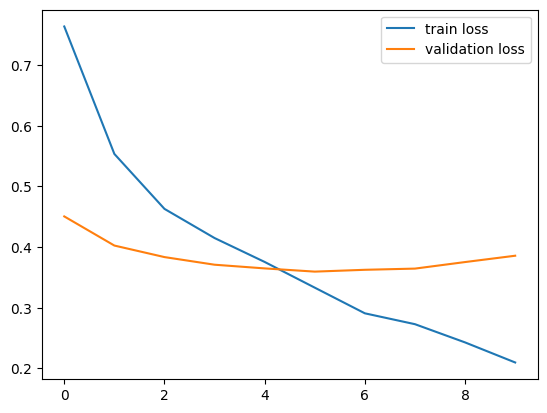

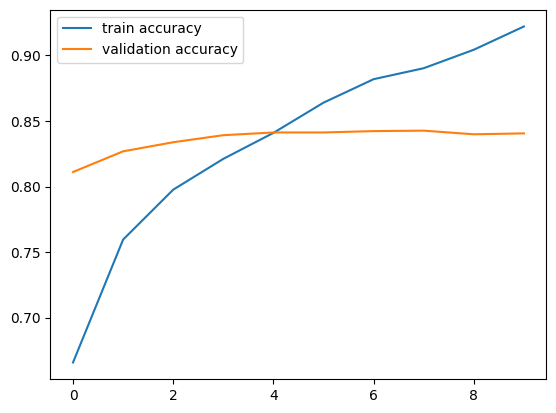

In [36]:
h = history

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()